## Import Necessary Libraries

In [1]:
# dataframes
import pandas as pd

# math, statistics
import math
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from patsy import dmatrices

# visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Create Functions

In [2]:
def csv_import(csv):
    '''Loads the requested csv file, and provides its shape, summary information, and count of null values
    
        @params
        csv is a .csv file
        df is a pd.DataFrame
        
        @output
        a pd.Dataframe
    
    '''
    df = pd.read_csv(csv)
    print('DATA FRAME SHAPE')
    print("========================================")
    print(df.shape)
    print("")
    print('DATA SUMMARY')
    print("========================================")
    print(df.info())
    print("")
    print("VALUE COUNTS FOR COLUMNS WITH NULL VALUES")
    print("========================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "VALUE COUNTS")
        print("--------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    return df

def describe_outliers(df):
    '''Calls the summary function, while also identifying the value three standard deviations away from the mean
    
            @params
            df is a pd.DataFrame
    
            @output
            summary of a pd.DataFrame.describe() with 3 standard deviations added
    '''
    print('DATA DESCRIPTION')
    print("========================================")
    describe = df.describe()

    describe.loc['+3_std'] = describe.loc['mean'] + (describe.loc['std'] * 3)
    describe.loc['-3_std'] = describe.loc['mean'] - (describe.loc['std'] * 3)
    print(describe)
    
def draw_qqplot(residual):
    fig, ax = plt.subplots(figsize=(6,2.5))
    _, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
    
    return fig, ax
    
def draw_scatter(y_pred, residual):
    fig, ax = plt.subplots(figsize=(6,2.5))
    _ = ax.scatter(y_pred, residual, color='blue')
    
    return fig, ax
    
def high_corr(df):
    '''Produces column interactions with a p value of .70 - .99
    
            @params
            df is a pd.DataFrame
    
            @output
            a df of highly-correlated columns and their pearson correlation score
    '''
    df_highcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_highcorr['Highly Correlated Pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
    df_highcorr.set_index(['Highly Correlated Pairs'], inplace = True)
    df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
    df_highcorr.columns = ['Correlation']
    df_highcorr.drop_duplicates(inplace=True)
    return df_highcorr[(df_highcorr.Correlation>.7) & (df_highcorr.Correlation<1)]
    
def log_transform(df,features):
    '''Runs a log transformation on a feature
    
        @params
        df is a pd.Dataframe
        features is a list of columns to be considered
        
        @output
        new log-transformed column
    
    '''
    for feature in features:
        df[feature + '_log'] = np.log(df[feature])
    return df
    
def quick_corrmap(df, features):
    '''Quickly produces a correlation heatmap
    
            @params
            df is a pd.DataFrame
            features is a list of columns to be considered
    
            @output
            correlation heat map
    '''
    mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True 

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Pearson Correlation Matrix',fontsize=25)

    sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

def reg_summary(X_train, y_train):
    X_with_constant = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_with_constant)
    results = model.fit()
    print(results.params)
    print(results.summary())
    return results
    
def remove_outliers(df, features):
    '''Removes outliers more than 3 standard deviations away from the mean for each listed feature
    
        @params
        df is a pd.Dataframe
        features is a list of columns to be considered
        
        @output
        df with outliers removed
    '''
    print("COUNT OF OUTLIERS REMOVED")
    print("========================================")
    
    x = len(df)
    
    for feature in features:
        df[feature + '_zscore'] = np.abs(stats.zscore(df[feature]))
        y = df.loc[np.abs(df[feature + '_zscore']) > 3]
        percent = round((len(y) * 100) / x, 3)
        
        print(len(y), "outliers removed for", feature)
        
        df = df.loc[np.abs(df[feature + '_zscore']) < 3]
        
        df = df.drop([feature + '_zscore'], axis=1)
    
    return df
    
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
    
def validate_changes(df):
    '''Loads the requested df, and provides its shape and count of null values; should be run after initial
        transformation
    
        @params
        df is a pd.DataFrame
        
        @output
        summary data
    
    '''
    print('DATA FRAME SHAPE')
    print("========================================")
    print(df.shape)
    print("")
    print("COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION")
    print("(Should Produce No Results Below Line)")
    print("========================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "VALUE COUNTS")
        print("--------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    print("")
    return df.head()

def validate_reg_assumptions(X, X_train, X_test, y_train, y_test):
    results = reg_summary(X_train, y_train)
    print(results)
    
    print('\nIdentifying Residuals...\n')
    X_test = sm.add_constant(X_test)
    y_pred = results.predict(X_test)
    residual = y_test - y_pred

    print('\nVerifying Normality of Residuals...\n')
    sns.distplot(residual)
    plt.show();
    draw_qqplot(residual)
    plt.show();
    print('Mean of Residuals: ', np.mean(residual))

    print('\nDisplaying Regplot...\n')
    draw_scatter(y_pred, residual)
    sns.regplot(y_pred, residual, color='red')

# Data Processing

## King County Housing Data Set (2015) 

### Obtaining Data

In [3]:
df_2015 = csv_import('kc_house_data.csv')

DATA FRAME SHAPE
(21597, 21)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), o

### Transforming Data

In [4]:
# remove waterfront and view data
df_2015 = df_2015.drop(['view', 'waterfront'], axis=1)

# convert basement_sqft to a boolean, and assume all "?" data does not have a basement
df_2015.loc[df_2015.sqft_basement == '?', 'sqft_basement'] = 0
df_2015['sqft_basement'] = df_2015.sqft_basement.astype(float)
df_2015['sqft_basement'] = df_2015.sqft_basement.astype(int)
df_2015['basement'] = (df_2015['sqft_basement'] > 0).astype(int)

# convert yr_renovated to renovated blooean
df_2015['renovated'] = (df_2015['yr_renovated'] > 0).astype(int)

# convert sale dates to seasons
df_2015['date'] = pd.to_datetime(df_2015['date'], format='%m/%d/%Y', errors='coerce')
df_2015['month'] = df_2015['date'].dt.month
season = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'fall',
    10: 'fall',
    11: 'fall',
    12: 'winter',
}
df_2015['season'] = df_2015['month'].replace(season)

# add season dummies
df_season = pd.get_dummies(df_2015['season'], drop_first=True)
df_2015 = pd.concat([df_2015, df_season], axis=1)

# drop columns that were used in scrubbing, have been replaced, or do not serve the analysis
df_2015 = df_2015.drop(['id','date','month','season','sqft_basement','yr_renovated'], axis = 1)

# change incorrect data types
df_2015['zipcode'] = df_2015['zipcode'].astype(int)
df_2015['price'] = df_2015['price'].astype(int)

In [5]:
validate_changes(df_2015)

DATA FRAME SHAPE
(21597, 20)

COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION
(Should Produce No Results Below Line)



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,spring,summer,winter
0,221900,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0,0,0,0
1,538000,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1,0,0,1
2,180000,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0,0,0,1
3,604000,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000,1,0,0,0,1
4,510000,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0,0,0,1


## Outside Data: Link Light Rail Data Set

Light Rail has existed in King County since 2009, and we believe that proximity to a Link Light Rail station will have a positive impact on housing price. For this reason, the first set of data we'll work on cleaning is a manually gathered link of Light Rail locations by zip code.

In [6]:
df_link = csv_import('light_rail.csv')

DATA FRAME SHAPE
(55, 8)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 8 columns):
Unnamed: 0              55 non-null object
Zip Code                36 non-null float64
Is Open                 55 non-null bool
Open                    55 non-null int64
Is Started              55 non-null bool
Construction Started    31 non-null float64
Is Announced            55 non-null bool
Announced               55 non-null int64
dtypes: bool(3), float64(2), int64(2), object(1)
memory usage: 2.4+ KB
None

VALUE COUNTS FOR COLUMNS WITH NULL VALUES
Zip Code VALUE COUNTS
--------------------
NaN        19
98004.0     5
98052.0     4
98188.0     3
98144.0     3
98118.0     2
98003.0     2
98101.0     2
98104.0     2
98133.0     2
98134.0     2
98032.0     1
98102.0     1
98108.0     1
98115.0     1
98195.0     1
98040.0     1
98105.0     1
98125.0     1
98005.0     1
Name: Zip Code, dtype: int64

Construction Started VALUE COUNTS
---------------

In [7]:
# drop rows where only a vote has occurred (no formal location)
df_link.dropna(subset=['Construction Started'], inplace=True)

# convert all floats to integers
df_link['Zip Code'] = df_link['Zip Code'].astype(int)
df_link['Open'] = df_link['Open'].astype(int)
df_link['Construction Started'] = df_link['Construction Started'].astype(int)
df_link['Announced'] = df_link['Announced'].astype(int) 
df_link['Is Open'] = df_link['Is Open'].astype(int)
df_link['Is Started'] = df_link['Is Started'].astype(int)
df_link['Is Announced'] = df_link['Is Announced'].astype(int) 

# only one row per zip code
df_link.drop_duplicates(subset=['Zip Code'],inplace=True)

# drop station name (unnecessary with cleaned data)
df_link = df_link.loc[:, ~df_link.columns.str.contains('^Unnamed')]

# rename remaining columns for clarity
df_link = df_link.rename(columns = {'Zip Code':'Zip Code','Is Open':'Link Open Nearby','Open':'Year Link Opened','Is Started':'Link Construction Started','Construction Started':'Year Construction Started','Is Announced':'Link Announced','Announced':'Year Link Announced'})

df_link = df_link[['Zip Code','Link Open Nearby','Link Construction Started','Link Announced']]

df_link.head()


,Zip Code,Link Open Nearby,Link Construction Started,Link Announced
0,98144,1,1,1
1,98108,1,1,1
2,98104,1,1,1
4,98118,1,1,1
7,98188,1,1,1


## Outside Data: 2015 to 2019 Price Trend Data

In [8]:
df_trends = csv_import('market_trend.csv')

DATA FRAME SHAPE
(66382, 12)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66382 entries, 0 to 66381
Data columns (total 12 columns):
Year                  1283 non-null float64
Zip Code              1283 non-null float64
Closings              1283 non-null object
 Sale Amt Avg         1283 non-null object
YoY Sale Amt Avg      1194 non-null object
 Price/ SqFt Avg      1283 non-null object
YoY Price/SqFt Avg    1194 non-null object
Bedrooms Avg          1283 non-null float64
Bathrooms  Avg        1283 non-null float64
Living SqFt Avg       1275 non-null object
Land SqFt Avg         1282 non-null object
Acres Avg             1283 non-null float64
dtypes: float64(5), object(7)
memory usage: 6.1+ MB
None

VALUE COUNTS FOR COLUMNS WITH NULL VALUES
Year VALUE COUNTS
--------------------
NaN       65099
2018.0       87
2012.0       87
2017.0       86
2016.0       86
2013.0       86
2006.0       86
2005.0       86
2019.0       85
2015.0       85
2014.0       85
2011.0      

In [9]:
# keep only 2015 and 2019 values
values_2015 = ['2015']
df_2015avg = df_trends[df_trends.Year.isin(values_2015)]
values_2019 = ['2019']
df_2019avg = df_trends[df_trends.Year.isin(values_2019)]
df_5comb = pd.merge(df_2015avg, df_2019avg, left_on ='Zip Code', right_on = 'Zip Code', how='left')

# drop blanks rows
df_5comb.dropna(subset=['Year_x'], inplace=True)
df_5comb.dropna(subset=['Year_y'], inplace=True)

# convert all floats to integers
df_5comb['Year_x'] = df_5comb['Year_x'].astype(int)
df_5comb['Year_y'] = df_5comb['Year_y'].astype(int)
df_5comb['Zip Code'] = df_5comb['Zip Code'].astype(int)
df_5comb[' Sale Amt Avg _x'] = df_5comb[' Sale Amt Avg _x'].str.replace(',', '').str.replace('$', '').astype(float)
df_5comb[' Sale Amt Avg _y'] = df_5comb[' Sale Amt Avg _y'].str.replace(',', '').str.replace('$', '').astype(float)

# created simplified DF
df_5yoy = df_5comb[['Zip Code','Year_x',' Sale Amt Avg _x','Year_y',' Sale Amt Avg _y']]

# determine price increase
df_5yoy['Price Increase Multiplier'] = df_5yoy[' Sale Amt Avg _y']/df_5yoy[' Sale Amt Avg _x']

# create final DF to merge with master dataset
df_increase = df_5yoy[['Zip Code','Price Increase Multiplier']]

df_increase.head()

,Zip Code,Price Increase Multiplier
0,98001,1.370913
1,98002,1.442513
2,98003,1.479901
3,98004,1.410100
4,98005,1.488590


## Combining Data Sets

Now that all of our data is pre-processed, we'll combine our three data sets.

In [10]:
# merge with Link data
df_with_Link = pd.merge(df_2015, df_link, left_on ='zipcode', right_on = 'Zip Code', how='left')

#fill NaN values for zip codes not year light rail
df_with_Link['Link Open Nearby'].fillna(value=0, inplace=True)
df_with_Link['Link Construction Started'].fillna(value=0, inplace=True)
df_with_Link['Link Announced'].fillna(value=0, inplace=True)

In [11]:
# merge with trend data
df_2019 = pd.merge(df_with_Link, df_increase, left_on ='zipcode', right_on = 'Zip Code', how='left')

# drop redundant columns that were generated because of table merges
df_2019 = df_2019.drop(['Zip Code_x','Zip Code_y'], axis = 1)

Using Price Increase Multiplier to Predict Current Home Price

In [12]:
df_2019['Est_2020_Price'] = (df_2019['price']*df_2019['Price Increase Multiplier']).round(-3)
df_2019 = df_2019.drop(['price','Price Increase Multiplier'], axis=1)

validate_changes(df_2019)

DATA FRAME SHAPE
(21597, 23)

COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION
(Should Produce No Results Below Line)



,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,...,sqft_lot15,basement,renovated,spring,summer,winter,Link Open Nearby,Link Construction Started,Link Announced,Est_2020_Price
0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,...,5650,0,0,0,0,0,0.0,0.0,0.0,335000.0
1,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,...,7639,1,1,0,0,1,0.0,1.0,1.0,773000.0
2,2,1.00,770,10000,1.0,3,6,770,1933,98028,...,8062,0,0,0,0,1,0.0,0.0,0.0,252000.0
3,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,...,5000,1,0,0,0,1,0.0,0.0,0.0,744000.0
4,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,...,7503,0,0,0,0,1,0.0,0.0,0.0,748000.0


# Data Exploration

## Find and Remove Outliers

In [13]:
describe_outliers(df_2019)

DATA DESCRIPTION
            bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count   21597.000000  21597.000000  21597.000000  2.159700e+04  21597.000000   
mean        3.373200      2.115826   2080.321850  1.509941e+04      1.494096   
std         0.926299      0.768984    918.106125  4.141264e+04      0.539683   
min         1.000000      0.500000    370.000000  5.200000e+02      1.000000   
25%         3.000000      1.750000   1430.000000  5.040000e+03      1.000000   
50%         3.000000      2.250000   1910.000000  7.618000e+03      1.500000   
75%         4.000000      2.500000   2550.000000  1.068500e+04      2.000000   
max        33.000000      8.000000  13540.000000  1.651359e+06      3.500000   
+3_std      6.152097      4.422779   4834.640225  1.393373e+05      3.113145   
-3_std      0.594303     -0.191127   -673.996525 -1.091385e+05     -0.124952   

           condition         grade    sqft_above      yr_built       zipcode  \
count   21597.000000  

In [14]:
# grab columns that have minimum and maximum data substantially higher than +/-3 std
outliers_2019 = df_2019[['bedrooms','bathrooms','sqft_living']]

In [15]:
df_2019 = remove_outliers(df_2019, outliers_2019)
df_2019.head()

COUNT OF OUTLIERS REMOVED
62 outliers removed for bedrooms
172 outliers removed for bathrooms
213 outliers removed for sqft_living


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,...,sqft_lot15,basement,renovated,spring,summer,winter,Link Open Nearby,Link Construction Started,Link Announced,Est_2020_Price
0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,...,5650,0,0,0,0,0,0.0,0.0,0.0,335000.0
1,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,...,7639,1,1,0,0,1,0.0,1.0,1.0,773000.0
2,2,1.00,770,10000,1.0,3,6,770,1933,98028,...,8062,0,0,0,0,1,0.0,0.0,0.0,252000.0
3,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,...,5000,1,0,0,0,1,0.0,0.0,0.0,744000.0
4,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,...,7503,0,0,0,0,1,0.0,0.0,0.0,748000.0


## Address Multicollinearity

In [16]:
# sm = pd.plotting.scatter_matrix(df_2019, figsize=[20, 20]);

# [s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
# [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# [s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

# [s.set_xticks(()) for s in sm.reshape(-1)]
# [s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()

In [17]:
high_corr(df_2019)

,Correlation
Highly Correlated Pairs,
"(sqft_above, sqft_living)",0.855326
"(sqft_living15, sqft_living)",0.752856
"(grade, sqft_living)",0.737630
"(grade, sqft_above)",0.728735
"(bathrooms, sqft_living)",0.725854
"(sqft_above, sqft_living15)",0.720120
"(sqft_lot, sqft_lot15)",0.700541


In [18]:
df_2019['sqft_living_MCfix'] = df_2019['sqft_living'] * df_2019['sqft_living15'] * df_2019['sqft_above']
df_2019['sqft_lot_MCfix'] = df_2019['sqft_lot'] * df_2019['sqft_lot15']
model_data = df_2019.drop(['sqft_living', 'sqft_living15','sqft_above','sqft_lot','sqft_lot15'], axis=1)

## Interactions 

In [19]:
# create interactions
model_data['rooms_interact'] = df_2019['bedrooms'] * df_2019['bathrooms']
model_data['density_interact'] = df_2019['sqft_living'] * df_2019['sqft_lot'] * df_2019['floors']
model_data['link'] = df_2019['Link Announced'] + df_2019['Link Construction Started'] + df_2019['Link Open Nearby']

In [20]:
high_corr(model_data)

,Correlation
Highly Correlated Pairs,
"(link, Link Announced)",0.976162
"(rooms_interact, bathrooms)",0.890025
"(bedrooms, rooms_interact)",0.808422
"(grade, sqft_living_MCfix)",0.728784


In [21]:
model_data = model_data.drop(['Link Announced','Link Construction Started','zipcode','bedrooms','bathrooms'],axis=1)

features = model_data.columns

high_corr(model_data)

,Correlation
Highly Correlated Pairs,
"(sqft_living_MCfix, grade)",0.728784


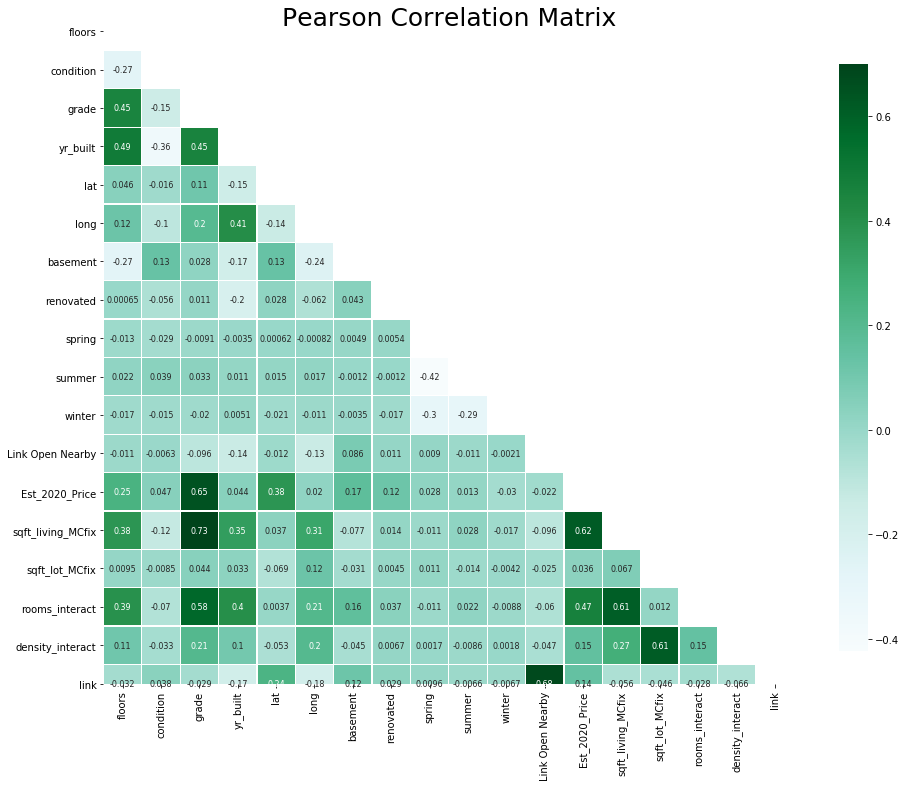

In [22]:
quick_corrmap(model_data,features)

In [23]:
x = model_data
X = x.drop(['Est_2020_Price'], axis=1)
y = x['Est_2020_Price']

result = stepwise_selection(X, y, verbose=True)
print('resulting features:')
print(result)


Add  grade                          with p-value 0.0
Add  sqft_living_MCfix              with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  lat                            with p-value 0.0
Add  rooms_interact                 with p-value 9.59923e-138
Add  basement                       with p-value 8.08105e-73
Add  condition                      with p-value 1.30745e-55
Add  link                           with p-value 1.45823e-53
Add  renovated                      with p-value 7.57224e-41
Add  spring                         with p-value 6.39321e-19
Add  long                           with p-value 2.83986e-15
Add  Link Open Nearby               with p-value 5.03362e-12
Add  sqft_lot_MCfix                 with p-value 6.47031e-12
Add  floors                         with p-value 9.3265e-10
resulting features:
['grade', 'sqft_living_MCfix', 'yr_built', 'lat', 'rooms_interact', 'basement', 'condition', 'link', 'renovated', 'spring', 'long', 'Link Open Nearby', 'sqft_

In [31]:
X = x[['grade', 'sqft_living_MCfix', 'yr_built', 'lat', 'rooms_interact', 'basement', 
    'condition', 'link', 'renovated', 'spring', 'long', 'Link Open Nearby', 'sqft_lot_MCfix', 'floors']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 62267379564.672554
Test Mean Squarred Error: 54546668018.79681


const               -4.402644e+07
grade                1.588759e+05
sqft_living_MCfix    1.248856e-05
yr_built            -2.771064e+03
lat                  7.477371e+05
rooms_interact       9.817161e+03
basement             6.955388e+04
condition            5.361468e+04
link                 4.230877e+04
renovated            1.173311e+05
spring               3.078796e+04
long                -1.063032e+05
Link Open Nearby    -7.213558e+04
sqft_lot_MCfix       1.379378e-06
floors               2.222698e+04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:         Est_2020_Price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2225.
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:23:36   Log-Likelihood:            -2.3428e+05
N

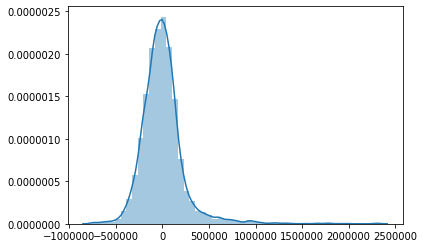

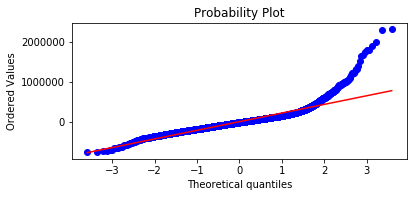

Mean of Residuals:  641.0724315433824

Displaying Regplot...



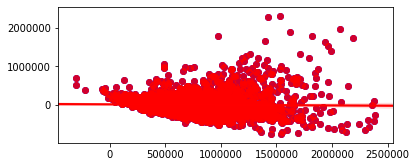

In [32]:
validate_reg_assumptions(X, X_train, X_test, y_train, y_test)